reference video: https://www.youtube.com/watch?v=jztwpsIzEGc&t=981s

In [6]:
import cv2
from matplotlib import pyplot as plt

We now try to take the data folder, and split it into multiple data folders, each of these folders containing one individual picture classification

BEFORE RUNNING THIS STEP: please have image folder in parent directory and data_classes folder in experimental


In [7]:

import os
import shutil


classes=set()

for image in os.listdir("../images"):
    classes.add(image[:2])

newlist=[]


for classname in list(classes):
    newstring=""
    for char in classname:
        if char.isnumeric():
            newstring+=char
    newlist.append(int(newstring))


parent_dir="../experimental/data_classes"
imagePath="../images"

for num in (newlist):
    dir_path = os.path.join(parent_dir, str(num))
    os.makedirs(dir_path, exist_ok=True)
    
    print(f"Directory {dir_path} created.")


for imagefilename in os.listdir("../images"):
    newstring=""
    for char in imagefilename[:2]:
        if char.isnumeric():
            newstring+=char
    targetdirectory=os.path.join(parent_dir, newstring)
    newimagepath=os.path.join(imagePath, imagefilename)
    shutil.move(newimagepath, targetdirectory)
    print("image moved")






Directory ../experimental/data_classes/7 created.
Directory ../experimental/data_classes/14 created.
Directory ../experimental/data_classes/22 created.
Directory ../experimental/data_classes/2 created.
Directory ../experimental/data_classes/5 created.
Directory ../experimental/data_classes/10 created.
Directory ../experimental/data_classes/17 created.
Directory ../experimental/data_classes/11 created.
Directory ../experimental/data_classes/12 created.
Directory ../experimental/data_classes/9 created.
Directory ../experimental/data_classes/15 created.
Directory ../experimental/data_classes/16 created.
Directory ../experimental/data_classes/4 created.
Directory ../experimental/data_classes/13 created.
Directory ../experimental/data_classes/1 created.
Directory ../experimental/data_classes/6 created.
Directory ../experimental/data_classes/21 created.
Directory ../experimental/data_classes/0 created.
Directory ../experimental/data_classes/18 created.
Directory ../experimental/data_classes/

image resizing testing, using this technique we can successfully resize the image to a standard size of 128,128,3, without sacrificing any major features of the photo 

In [66]:
from PIL import Image
import matplotlib.pyplot as plt

'''
img = Image.open('../experimental/data_classes/10/10_577.png') 
new_img = img.resize((128, 128))
new_img.save("../experimental/resized_image/image.png")
'''

old_img_array=cv2.imread('../experimental/data_classes/10/10_577.png')
new_img_array=cv2.imread("../experimental/resized_image/image.png")
print(old_img_array.shape)
print(new_img_array.shape)


plt.imshow(cv2.cvtColor(old_img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

plt.imshow(cv2.cvtColor(new_img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

NameError: name 'cv2' is not defined

Now we try to construct an image daatset from our image_directory, which is already nicely split up for us. There is a keras library for this:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [1]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt

data=tf.keras.utils.image_dataset_from_directory("../experimental/data_classes",
                                                image_size=(256, 256),
                                                batch_size=64,
                                                )

data_iterator= data.as_numpy_iterator()
batch=data_iterator.next()
print(batch[0].shape) #indepenedant variables i.e pixel values
print(batch[1].shape) #y labels


Found 4896 files belonging to 23 classes.
(64, 256, 256, 3)
(64,)


lets have a look at the max and min values of each pixel, we can see that pixels take a max and min value of 255 and 0 respectively. This means that to normalise, we simply take the values and divide it by range: 255

In [2]:
print("Max value of pixels: ", batch[0].max())
print("Min value of pixels: ", batch[0].min())

Max value of pixels:  255.0
Min value of pixels:  0.0


lets normalise the data, run this only ONCE PLEASE

In [3]:
data=data.map(lambda x, y: (x/255, y))

as can be seen, values should now be represented in zero to one ranges

In [4]:
scaled_data_iterator=data.as_numpy_iterator()
scaled_batch=scaled_data_iterator.next()
print(scaled_batch[0].min())
print(scaled_batch[0].max())

0.0
1.0


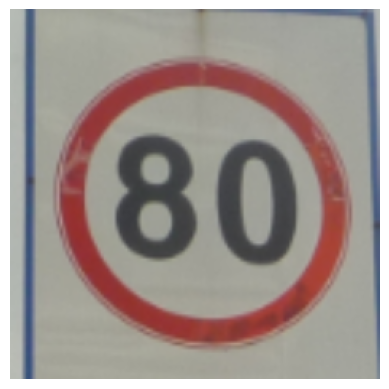

In [5]:
example_image = scaled_batch[0][0] 
plt.imshow(example_image)  
plt.axis('off')  
plt.show()

With a batch size of 64, there are still 77 batches, so we will split it into train, test, and validation sets. 

train set= 70%
validation set= 20%
test set= 10%


In [6]:
numBatch=len(data)
trainsize=int(0.7*numBatch)
valsize=int(0.2*numBatch)+1
testsize=int(0.1*numBatch)+1


now we distribute the train, val and test set

In [7]:
train=data.take(trainsize)
val=data.skip(trainsize).take(valsize)
test=data.skip(trainsize+valsize).take(testsize)

In [8]:
print(len(train))
print(len(val))
print(len(test))

53
16
8


In [12]:
import torch 

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

NameError: name 'torch' is not defined

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [11]:
model=Sequential()

In [12]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(23, activation='softmax'))

/Users/sydneysim/Documents/Y2S1/IT1244/project/IT1244_Project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


as we can see the output is not one hot encoded, so we use sparese 

In [13]:
train.as_numpy_iterator().next()[1]

array([ 6, 21, 13,  3, 20, 17,  5, 12, 22,  0, 22, 10, 16,  1, 16,  2,  6,
       16, 10, 15, 22,  7,  5, 12, 19, 12,  2, 14, 10, 21, 22, 19, 12,  5,
       11,  1, 20, 12, 14,  1,  9, 17,  8,  4,  0,  0,  0, 12, 16,  4,  1,
       10,  3, 21, 10, 15, 13,  9,  4, 16, 14, 12, 10, 22], dtype=int32)

In [14]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,702,279 (14.12 MB)

 Trainable params: 3,702,279 (14.12 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
hist = model.fit(train, batch_size=64, epochs=5, validation_data=val, callbacks=[tensorboard_callback], verbose=1)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3322 - loss: 2.2779 - val_accuracy: 0.7930 - val_loss: 0.6959
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8577 - loss: 0.4657 - val_accuracy: 0.9570 - val_loss: 0.1665
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9615 - loss: 0.1159 - val_accuracy: 0.9541 - val_loss: 0.1737
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9831 - loss: 0.0698 - val_accuracy: 0.9912 - val_loss: 0.0407
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9968 - loss: 0.0125 - val_accuracy: 0.9863 - val_loss: 0.0441


In [23]:
hist

import tensorflow as tf

data=tf.keras.utils.image_dataset_from_directory("../experimental/data_classes",
                                                image_size=(256, 256),
                                                batch_size=64,
                                                )

data_iterator= data.as_numpy_iterator()
batch=data_iterator.next()
print(batch[0].shape) #indepenedant variables i.e pixel values
print(batch[1].shape) #y labels
print("Max value of pixels: ", batch[0].max())
print("Min value of pixels: ", batch[0].min())
data=data.map(lambda x, y: (x/255, y))
scaled_data_iterator=data.as_numpy_iterator()
scaled_batch=scaled_data_iterator.next()
print(scaled_batch[0].min())
print(scaled_batch[0].max())
example_image = scaled_batch[0][0] 
plt.imshow(example_image)  
plt.axis('off')  
plt.show()
import cv2
from matplotlib import pyplot as plt
example_image = scaled_batch[0][0] 
plt.imshow(example_image)  
plt.axis('off')  
plt.show()
numBatch=len(data)
trainsize=int(0.

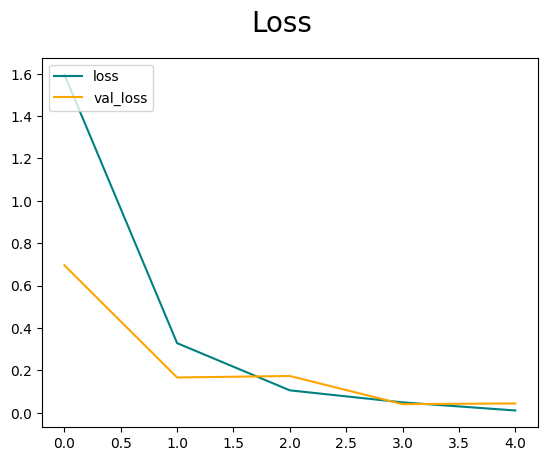

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

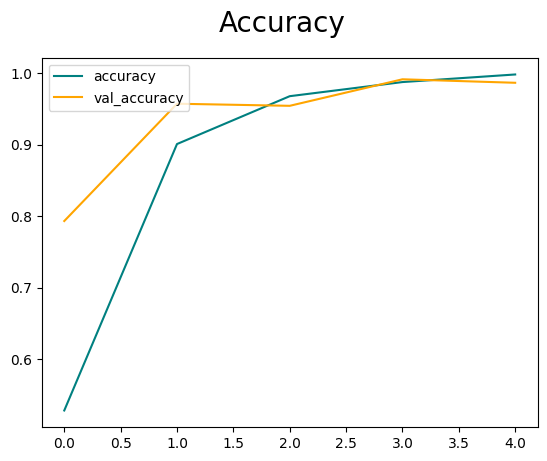

In [19]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [42]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np

In [43]:
pre=Precision()
rec=Recall()
acc=Accuracy()

In [44]:
for batch in test.as_numpy_iterator():
    x,y=batch
    predicted=model.predict(x)
    yhat=np.argmax(predicted, axis=1)
    acc.update_state(y, yhat)
    rec.update_state(y, yhat)
    pre.update_state(y, yhat)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


In [45]:
print(pre.result(), rec.result(), acc.result())

tf.Tensor(0.9976526, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9791667, shape=(), dtype=float32)
